In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import h5py
from pathlib import Path
from typing import Union, Optional, Callable
from tqdm.notebook import tqdm

## `TrackMLDataset` class

In [2]:
class TrackMLDataset(Dataset):
    r"""
    A Dataset subclass for the TrackML dataset in HDF5 format.

    Args:
        file (str or Path): path to the HDF5 file holding the data.
        scaling_factor (float, optional): a multiplicative scaling factor applied to the hit positions (default: ``1.0``).
            Note that, by default, positions are specified in millimeters.
        transform (Callable, optional): a function used to further process the output.
        float_dtype (torch.dtype, optional): the dtype of the returned tensors for floating-point features (default: ``torch.float32``).
    """

    def __init__(
        self,
        file: Union[str,Path],
        scaling_factor: float=1.0,
        transform: Optional[Callable]=None,
        float_dtype=torch.float32,
    ):
        super(TrackMLDataset).__init__()
        self.file = h5py.File(file, 'r')
        self.number_of_events = self.file.attrs['number_of_events']
        self.hits = self.file['hits']
        self.truth = self.file['truth']
        self.float_dtype = float_dtype
        self.scaling_factor = torch.tensor(scaling_factor, dtype=float_dtype)
        self.transform = transform

    def __del__(self):
        self.file.close()

    def __len__(self):
        return self.number_of_events

    def __getitem__(self, idx: int):
        x, hit_id = self._get_hits(idx)
        pids = self._get_particle_ids(idx, hit_id)
        output = {
            'x': x,
            'mask': torch.ones(x.shape[0], dtype=bool),
            'pids': pids,
            'event': None,
        }
        if self.transform:
            output = self.transform(output)
        return output

    def _get_hits(self, idx: int):
        offset = self.hits['event_offset'][idx]
        length = self.hits['event_length'][idx]
        event_slice = slice(offset, offset+length)
        hit_id = pd.DataFrame({'hit_id': self.hits['hit_id'][event_slice]}, copy=False).set_index('hit_id')
        x = torch.zeros((length, 3), dtype=self.float_dtype)
        x[:,0] = torch.from_numpy(self.hits['x'][event_slice]) * self.scaling_factor
        x[:,1] = torch.from_numpy(self.hits['y'][event_slice]) * self.scaling_factor
        x[:,2] = torch.from_numpy(self.hits['z'][event_slice]) * self.scaling_factor
        return x, hit_id

    def _get_particle_ids(self, idx: int, detected_hits: pd.DataFrame):
        # Note: not all hits in "hits" are also in "truth", and reciprocally
        # Note: the weight is ignored for now
        offset = self.truth['event_offset'][idx]
        length = self.truth['event_length'][idx]
        event_slice = slice(offset, offset+length)
        truth = pd.DataFrame({
            'hit_id': self.truth['hit_id'][event_slice],
            'particle_id': self.truth['particle_id'][event_slice],
        }, copy=False).set_index('hit_id')
        # Let’s find the true particle_id corresponding to each detected hit_id
        joined = detected_hits.join(truth, on='hit_id', how='inner')
        assert joined['particle_id'].dtype == truth['particle_id'].dtype
        matched_particle_id = torch.from_numpy(joined['particle_id'].values)
        return matched_particle_id


In [3]:
dset = TrackMLDataset('../TrackML.hdf5', scaling_factor=1e-3)

In [4]:
dset[0]

{'x': tensor([[-7.2719e-02, -7.7544e-03, -1.5025e+00],
         [-3.3899e-02, -1.9407e-03, -1.5025e+00],
         [-6.1312e-02,  5.6630e-04, -1.5025e+00],
         ...,
         [-8.1239e-01,  1.0628e-01,  2.9445e+00],
         [-7.7300e-01,  7.1169e-02,  2.9445e+00],
         [-9.7192e-01,  5.0928e-02,  2.9525e+00]]),
 'mask': tensor([True, True, True,  ..., True, True, True]),
 'pids': tensor([571961275844657152, 626005708323684352, 216174637539655680,
          ...,                  0, 499902238697717760,
         675548946357026816]),
 'event': None}

## Plot an event

In [5]:
from matplotlib import pyplot as plt

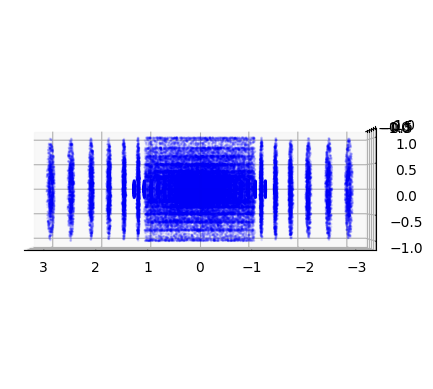

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*dset[0]['x'].T, s=1, color='blue', alpha=0.1)
ax.set_aspect('equal')
ax.view_init(elev=0, azim=0, roll=90)

## Do some benchmarking

In [7]:
%load_ext line_profiler

In [8]:
def microbenchmark(n=100):
    for i in range(n):
        dset[i]

In [9]:
%lprun -f TrackMLDataset.__getitem__ -f TrackMLDataset._get_hits -f TrackMLDataset._get_particle_ids microbenchmark(1000)

Timer unit: 1e-09 s

Total time: 12.4252 s
File: /var/folders/s9/hd7d27l173l6k8fr6dngbt9h0000gn/T/ipykernel_10436/3073654677.py
Function: __getitem__ at line 35

Line #      Hits         Time  Per Hit   % Time  Line Contents
    35                                               def __getitem__(self, idx: int):
    36      1000 5990610000.0    6e+06     48.2          x, hit_id = self._get_hits(idx)
    37      1000 6378935000.0    6e+06     51.3          pids = self._get_particle_ids(idx, hit_id)
    38      1000     374000.0    374.0      0.0          output = {
    39      1000     162000.0    162.0      0.0              'x': x,
    40      1000   54205000.0  54205.0      0.4              'mask': torch.ones(x.shape[0], dtype=bool),
    41      1000     191000.0    191.0      0.0              'pids': pids,
    42      1000     137000.0    137.0      0.0              'event': None,
    43                                                   }
    44      1000     421000.0    421.0      0.0 

In [10]:
%%time
for i in tqdm(range(1000)):
    dset[i]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 49.2 s, sys: 38.7 s, total: 1min 27s
Wall time: 9.82 s


## Test the compatibility with `WedgePatchify`

Modified version for 3d, which lacks the $p_\mathrm{T}$ target (because it requires the `event` key to be present).

In [11]:
import torch
from typing import Dict

class WedgePatchify3d:
    """
    A class to transform hitwise data into wedges of annuli.

    Give an event of shape [num_hits, 3] (x, y, z), return two mask tensors (context, target) of shape [num_hits]
    """

    def __init__(self, phi_range: float, eta_range: float, radius_midpoint: float, random_context: bool = True):
        self.phi_range = phi_range
        self.eta_range = eta_range
        self.radius_midpoint = radius_midpoint
        self.random_context = random_context

    def __call__(self, sample: Dict) -> Dict:
        """
        Apply the WedgePatchify transform to the input sample.

        Args:
            sample (Dict): A dictionary containing hitwise data. Must include an 'x' key
                           with a tensor of shape (num_hits, 3).

        Returns:
            Dict: The transformed sample with context, target, and mask tensors.
        """
        x, y, z = self._extract_coordinates(sample)
        radius, phi, eta = self._calculate_radius_phi_and_eta(x, y, z)
        selected_phi = self._select_random_phi(phi)
        phi_mask = self._create_phi_mask(phi, selected_phi)
        selected_eta = self._select_random_eta(eta)
        eta_mask = self._create_eta_mask(eta, selected_eta)
        inner_mask, outer_mask = self._create_radius_masks(radius)
        context_mask, target_mask = self._assign_masks(inner_mask, outer_mask, phi_mask, eta_mask)

        sample["context_mask"] = context_mask
        sample["target_mask"] = target_mask

        return sample

    def _extract_coordinates(self, sample: Dict) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        x = sample["x"][:, 0]
        y = sample["x"][:, 1]
        z = sample["x"][:, 2]
        return x, y, z

    def _calculate_radius_phi_and_eta(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        radius = torch.sqrt(x**2 + y**2)
        norm = torch.sqrt(x**2 + y**2 + z**2)
        phi = torch.atan2(y, x)  # Returns values between -pi and pi
        eta = torch.atanh(z / norm)
        return radius, phi, eta

    def _select_random_phi(self, phi: torch.Tensor) -> torch.Tensor:
        hit_idx = torch.randint(0, phi.shape[0], (1,))
        return phi[hit_idx]

    def _select_random_eta(self, eta: torch.Tensor) -> torch.Tensor:
        hit_idx = torch.randint(0, eta.shape[0], (1,))
        return eta[hit_idx]

    def _create_phi_mask(self, phi: torch.Tensor, selected_phi: torch.Tensor) -> torch.Tensor:
        phi_min = selected_phi - self.phi_range / 2
        phi_max = selected_phi + self.phi_range / 2
        return torch.logical_or(
            torch.logical_and(phi >= phi_min, phi <= phi_max),
            torch.logical_and(phi + 2*torch.pi >= phi_min, phi + 2*torch.pi <= phi_max)
        )

    def _create_eta_mask(self, eta: torch.Tensor, selected_eta: torch.Tensor) -> torch.Tensor:
        eta_min = selected_eta - self.eta_range / 2
        eta_max = selected_eta + self.eta_range / 2
        return torch.logical_and(eta >= eta_min, eta <= eta_max)

    def _create_radius_masks(self, radius: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        inner_mask = radius <= self.radius_midpoint
        outer_mask = radius > self.radius_midpoint
        return inner_mask, outer_mask

    def _assign_masks(self, inner_mask: torch.Tensor, outer_mask: torch.Tensor, phi_mask: torch.Tensor, eta_mask: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        if self.random_context and torch.rand(1).item() > 0.5:
            context_mask = inner_mask & phi_mask & eta_mask
            target_mask = outer_mask & phi_mask & eta_mask
        else:
            context_mask = outer_mask & phi_mask & eta_mask
            target_mask = inner_mask & phi_mask & eta_mask
        return context_mask, target_mask

In [12]:
torch.random.manual_seed(42)
patchify = WedgePatchify3d(phi_range=torch.pi/2, eta_range=0.5, radius_midpoint=0.5) # Very approximate midpoint

In [13]:
dset = TrackMLDataset('../TrackML.hdf5', transform=patchify, scaling_factor=1e-3)

In [14]:
sample = dset[0]

In [15]:
sample['context_mask'].float().mean()

tensor(0.0060)

In [16]:
sample['target_mask'].float().mean()

tensor(0.0113)

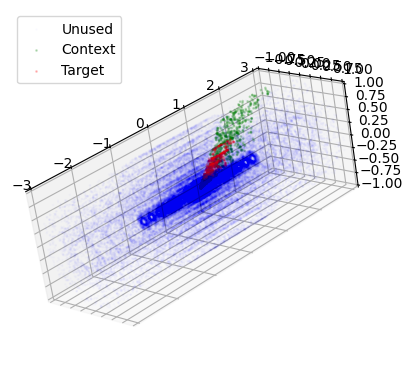

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
unmasked = ~(sample['context_mask'] | sample['target_mask'])
ax.scatter(*sample['x'][unmasked,:].T, s=1, color='blue', alpha=0.01, label='Unused')
ax.scatter(*sample['x'][sample['context_mask'],:].T, s=1, color='green', alpha=0.2, label='Context')
ax.scatter(*sample['x'][sample[ 'target_mask'],:].T, s=1, color='red'  , alpha=0.2, label='Target' )
ax.set_aspect('equal')
ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))
ax.set_zlim((-3,+3))
ax.view_init(elev=-140, azim=-120, roll=120)
ax.legend()

In [18]:
def microbenchmark(n=100):
    for i in range(n):
        dset[i]

In [19]:
%lprun -f TrackMLDataset.__getitem__ -f WedgePatchify3d.__call__ microbenchmark(1000)

Timer unit: 1e-09 s

Total time: 11.5944 s
File: /var/folders/s9/hd7d27l173l6k8fr6dngbt9h0000gn/T/ipykernel_10436/3073654677.py
Function: __getitem__ at line 35

Line #      Hits         Time  Per Hit   % Time  Line Contents
    35                                               def __getitem__(self, idx: int):
    36      1000 4222531000.0    4e+06     36.4          x, hit_id = self._get_hits(idx)
    37      1000 5401705000.0    5e+06     46.6          pids = self._get_particle_ids(idx, hit_id)
    38      1000     455000.0    455.0      0.0          output = {
    39      1000     178000.0    178.0      0.0              'x': x,
    40      1000  155613000.0 155613.0      1.3              'mask': torch.ones(x.shape[0], dtype=bool),
    41      1000     191000.0    191.0      0.0              'pids': pids,
    42      1000     146000.0    146.0      0.0              'event': None,
    43                                                   }
    44      1000     617000.0    617.0      0.0 

## Print the trajectory of one particle

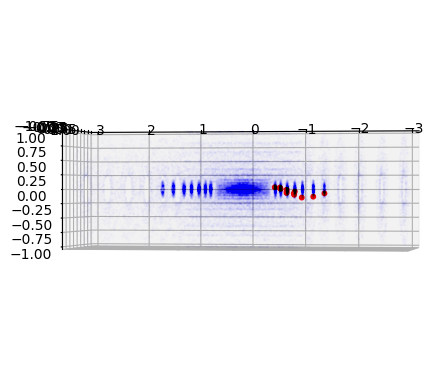

In [20]:
particle_hits = sample['pids'] == sample['pids'][0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
unmasked = ~(sample['context_mask'] | sample['target_mask'])
ax.scatter(*sample['x'].T, s=1, color='blue', alpha=0.005)
ax.scatter(*sample['x'][particle_hits].T, s=10, color='red', alpha=1)
ax.set_aspect('equal')
ax.set_xlim((-1,+1))
ax.set_ylim((-1,+1))
ax.set_zlim((-3,+3))
ax.view_init(elev=-170, azim=90, roll=-90)

## Test the compatibility with `Subset`

In [21]:
from torch.utils.data import Subset

In [22]:
sub = Subset(dset, range(100, 200))
len(sub)

100

In [23]:
sub[0]

{'x': tensor([[-0.0902, -0.0105, -1.5025],
         [-0.0797, -0.0063, -1.5025],
         [-0.0570, -0.0119, -1.5025],
         ...,
         [-0.9891,  0.1094,  2.9525],
         [-0.9614,  0.0526,  2.9525],
         [-0.8781,  0.0513,  2.9525]]),
 'mask': tensor([True, True, True,  ..., True, True, True]),
 'pids': tensor([499899764796555264, 765619495795425280, 423340495276605440,
          ..., 351293209160187904, 549441422281932800,
                          0]),
 'event': None,
 'context_mask': tensor([False, False, False,  ..., False, False, False]),
 'target_mask': tensor([False, False, False,  ..., False, False, False])}

In [24]:
dset[100]

{'x': tensor([[-0.0902, -0.0105, -1.5025],
         [-0.0797, -0.0063, -1.5025],
         [-0.0570, -0.0119, -1.5025],
         ...,
         [-0.9891,  0.1094,  2.9525],
         [-0.9614,  0.0526,  2.9525],
         [-0.8781,  0.0513,  2.9525]]),
 'mask': tensor([True, True, True,  ..., True, True, True]),
 'pids': tensor([499899764796555264, 765619495795425280, 423340495276605440,
          ..., 351293209160187904, 549441422281932800,
                          0]),
 'event': None,
 'context_mask': tensor([False, False, False,  ..., False, False, False]),
 'target_mask': tensor([False, False, False,  ..., False, False, False])}

In [25]:
sub[-1]

{'x': tensor([[-4.7994e-02,  3.4199e-03, -1.5025e+00],
         [-5.7874e-02,  1.3384e-03, -1.5025e+00],
         [-8.9232e-02, -1.4421e-02, -1.5025e+00],
         ...,
         [-9.3333e-01,  1.7878e-03,  2.9525e+00],
         [-9.9372e-01,  3.5647e-02,  2.9525e+00],
         [-9.3685e-01,  1.1143e-01,  2.9525e+00]]),
 'mask': tensor([True, True, True,  ..., True, True, True]),
 'pids': tensor([680053370618118144, 396320478060347392, 346785074047352832,
          ..., 238693322871275520, 409829833833447424,
         346783287340957696]),
 'event': None,
 'context_mask': tensor([False, False, False,  ..., False, False, False]),
 'target_mask': tensor([False, False, False,  ..., False, False, False])}

In [26]:
dset[199]

{'x': tensor([[-4.7994e-02,  3.4199e-03, -1.5025e+00],
         [-5.7874e-02,  1.3384e-03, -1.5025e+00],
         [-8.9232e-02, -1.4421e-02, -1.5025e+00],
         ...,
         [-9.3333e-01,  1.7878e-03,  2.9525e+00],
         [-9.9372e-01,  3.5647e-02,  2.9525e+00],
         [-9.3685e-01,  1.1143e-01,  2.9525e+00]]),
 'mask': tensor([True, True, True,  ..., True, True, True]),
 'pids': tensor([680053370618118144, 396320478060347392, 346785074047352832,
          ..., 238693322871275520, 409829833833447424,
         346783287340957696]),
 'event': None,
 'context_mask': tensor([False, False, False,  ..., False, False, False]),
 'target_mask': tensor([False, False, False,  ..., False, False, False])}

In [27]:
for evt in tqdm(sub):
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

## Check for invalid values

In [28]:
import logging

def check_valid(event):
    invalid = (
        event['x'].isnan().any() or
        event['mask'].isnan().any() or
        event['pids'].isnan().any()
    )
    if 'context_mask' in event or 'target_mask' in event:
        invalid = invalid or (
            event['context_mask'].isnan().any() or
            event['target_mask'].isnan().any()
        )
    return not invalid

In [29]:
for (i, evt) in enumerate(tqdm(dset)):
    if not check_valid(evt):
        logging.warning(f'Invalid value encountered in sample {i}')

  0%|          | 0/8743 [00:00<?, ?it/s]